#### Подключение библиотек и скриптов

In [1]:
import pandas as pd
import numpy as np

import sklearn as skl
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.svm import SVR

import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

#### Пути к директориям и файлам

In [4]:
# У меня файлы были в той же папке, что и ноутбук, поэтому просто указал имена файлов.
TRAIN_DATASET_PATH = 'train.csv'#'/kaggle/input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = 'test.csv'#'/kaggle/input/real-estate-price-prediction-moscow/test.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [6]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [7]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [8]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте:', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте: 5000


In [9]:
train_df.shape[1] - 1 == test_df.shape[1]

True

### Распределение и корреляция целевого признака

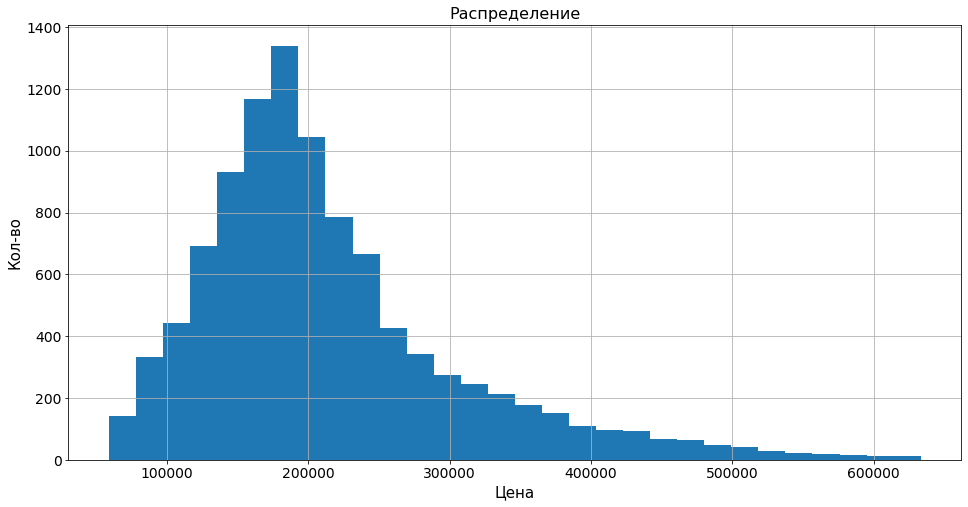

In [10]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Кол-во', fontsize=15) 
plt.xlabel('Цена', fontsize=15)

plt.title('Распределение', fontsize=16)
plt.show()

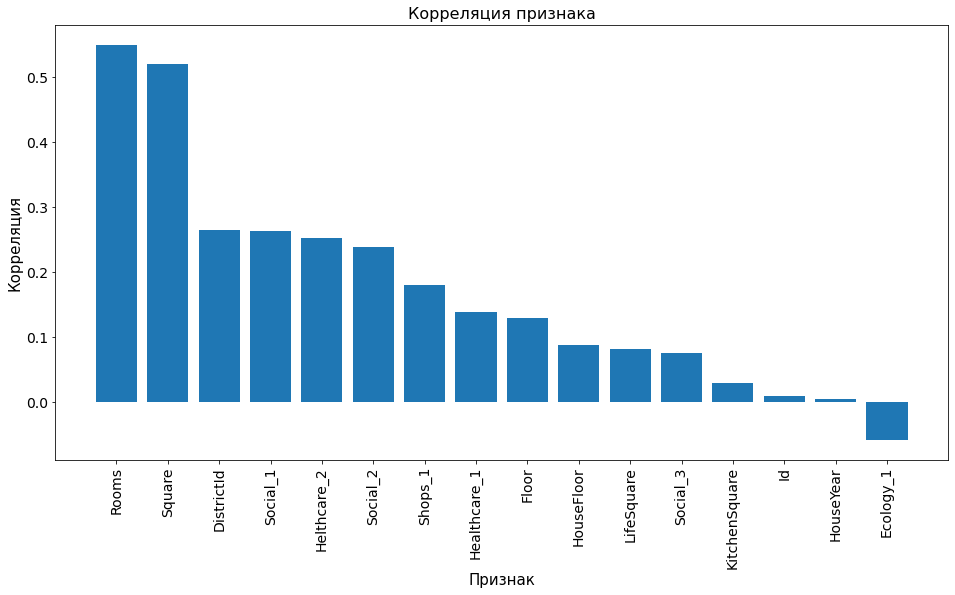

In [11]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')

plt.xlabel('Признак', fontsize=15)
plt.ylabel('Корреляция', fontsize=15)

plt.title('Корреляция признака', fontsize=16)
plt.show()

### Обработка данных и построение новых признаков

In [12]:
class DataPreprocessor:
    def __init__(self):
        self.medians = None
        self.kitchen_square_max_value = None
        self.kitchen_square_min_value = None
        self.life_square_min_value = None
        self.max_floor = None
        self.districts_healthcare = None


        
    def fit(self, df):
        # Медианы и квантили
        self.medians = df.median() # medians
        self.kitchen_square_max_value = np.quantile(df['KitchenSquare'], q=0.999)
        self.kitchen_square_min_value = np.quantile(df['KitchenSquare'], q=0.001)
        self.life_square_min_value = np.quantile(df['LifeSquare'], q=0.03)
        self.max_floor = df['Floor'].max()
        
        
        # Подсчёт среднего значения Helthcare_1 в каждом районе
        self.districts_healthcare = df.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()


    def transform(self, df):
        # Заполнение пропусков Life Square
        df['LifeSquare'].fillna(((df['Square'] - df['KitchenSquare']) - df['Square']*0.2), inplace=True)


        # Rooms
        # Заполнение медианами         
        df['Rooms'].fillna(self.medians.Rooms, inplace=True) 
        
        # Подсчёт медиан room square и заполнение выбросов по формуле (LifeSquare/Room_square) 
        condition_rooms = (df['Rooms'] > 6) | (df['Rooms'] == 0)   
        room_sq = np.round((self.medians.LifeSquare / self.medians.Rooms, 1))[0]
        df.loc[condition_rooms , 'Rooms'] = df.loc[condition_rooms, 'LifeSquare'] / room_sq

        # Square
        # Если LifeSquare больше Square, меняем значения местами
        df['Square'], df['LifeSquare'] = np.where(df['Square'] < df['LifeSquare'],(df['LifeSquare'],df['Square']), (df['Square'],df['LifeSquare']))


        # LifeSquare
        # Заполнение выбросов по формуле (Square - KithcenSquare)
        ls_condition = (df['LifeSquare'] < self.life_square_min_value)
        df.loc[ls_condition, 'LifeSquare'] = df.loc[ls_condition, ['Square']] - df.loc[ls_condition, ['KitchenSquare']]
  
        
        # KitchenSquare
        # Заполнение выбросов по формуле (Square - LifeSquare - 10% of Square)
        condition_kitchen_square = (df['KitchenSquare'] > self.kitchen_square_max_value) | (df['KitchenSquare'] < self.kitchen_square_min_value)
        df.loc[condition_kitchen_square, 'KitchenSquare'] = df.loc[condition_kitchen_square, 'Square'] - df.loc[condition_kitchen_square, 'LifeSquare'] \
        - (df.loc[condition_kitchen_square, 'Square'] * 0.1)


        # Ecology и Shops
        # Перевод в бинарные значения
        df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)
        
        
        # HouseFloor
        # Если HouseFloor меньше Floor - поменять значения местами
        house_floor_condition = df['HouseFloor'] < df['Floor']
        df.loc[house_floor_condition, 'HouseFloor'] = df.loc[house_floor_condition, 'Floor']

        
        # HouseYear
        # Если HouseYear больше текущего года - заменить медианным значением
        current_year = datetime.now().year
        condition_year = (df['HouseYear'] > current_year)
        df.loc[condition_year, 'HouseYear'] = self.medians.HouseYear
        
        
        # Healthcare
        # Заполнение пропусков значением Healthcare для района. 
        # Если у района нет значения Healthcare - заполнить медианным значением
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = df['DistrictId'].map(self.districts_healthcare)
        df['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True)       
        # Установка верхней квантили
        q_max = np.quantile(df['Healthcare_1'], q=0.9)
        df['Healthcare_1'].clip(upper=q_max, axis=0, inplace=True)
        
        
        # Выкидываем Id
        df.drop(['Id'], axis=1, inplace=True)

        
        # Заполнение пропусков медианами там, где не прописано отдельно
        df.fillna(self.medians, inplace=True)
        return df




In [13]:
class FeatureGenerator:
    def __init__(self):
        self.districts_median_year = None
        self.districts_density = None
        self.district_price_per_square = None
        self.min_sq = None
        self.max_sq = None

        
    def fit(self, df):   
        self.max_sq = np.quantile(df['Square'], q=0.995)
        self.min_sq = np.quantile(df['Square'], q=0.005)
        
        self.districts_median_year = df.groupby(['DistrictId'])['HouseYear'].agg('median').to_dict()  # median house year in each district
        self.districts_density = df.groupby(['DistrictId'])['Square'].agg('median').to_dict()  # median square in each district
        self.district_price_per_square = df.groupby(['DistrictId'])['Price'].agg('median') \
        / df.groupby(['DistrictId'])['Square'].agg('median')  # median price for square meter in each district
        
    
    def new_features(self, df):
        # "Возраст" района
        df['DistrictYear'] = df['DistrictId'].map(self.districts_median_year)
        
        self.median_district_year = df['DistrictYear'].median()
        df['DistrictYear'].fillna(self.median_district_year, inplace=True)


        # Медианное значение площади квартиры в каждом районе
        df['DistrictDensity'] = df['DistrictId'].map(self.districts_density)
        
        self.median_district_density = df['DistrictDensity'].median()
        df['DistrictDensity'].fillna(self.median_district_density, inplace=True)


        # Медианная цена за кв.м в каждом районе
        self.district_price_per_square.to_dict()
        df['DistrictPrice'] = df['DistrictId'].map(self.district_price_per_square)
        
        self.median_district_price_per_square = df['DistrictPrice'].median()
        df['DistrictPrice'].fillna(self.median_district_price_per_square, inplace=True)


        # Категория этажа
        floor_bins = [0, 4, 7, 12, df['Floor'].max()]
        df['Floor_cat'] = pd.cut(df['Floor'], bins=floor_bins, labels=False)
        df['Floor_cat'].fillna(-1, inplace=True) 

        
        # Масштабирование и слияние Social
        scaler = RobustScaler()
        pca = PCA(n_components=1, random_state=42)
        social_scaled = pd.DataFrame(scaler.fit_transform(df[['Social_1', 'Social_2', 'Social_3']]))
        df['Social'] = pca.fit_transform(social_scaled)
        
        df.drop(['Ecology_2', 'Ecology_3', 'Shops_2', 'Helthcare_2', 'Floor',], axis=1, inplace=True)
        
        return df
    
    
    def drop_outliers(self, df):
        df = df.loc[(df['Square'] > self.min_sq) & (df['Square'] < self.max_sq)]
        
        
        return df

#### Предобработка данных

In [14]:
preprocessor = DataPreprocessor()
preprocessor.fit(train_df)
train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

#### Генерация новых признаков

In [15]:
features_gen = FeatureGenerator()
features_gen.fit(train_df)
train_df = features_gen.new_features(train_df)
train_df = features_gen.drop_outliers(train_df)
test_df = features_gen.new_features(test_df)

#### Разбиение на train  и test

In [16]:
y = pd.DataFrame(data=train_df['Price'])
train_df.drop('Price', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.15, random_state=100)


### Обучение и оценка модели Gradient Boosting Regressor на тренировочном датасете

In [17]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=60,
                                     random_state=42,  
                                     n_estimators=2250, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)

gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)
print('r2 train:', r2(y_train, y_train_preds))
print('r2 test:', r2(y_test, y_test_preds))

r2 train: 0.8587288928961601
r2 test: 0.800636930260506


#### Важность признаков

In [18]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
2,Square,0.271832
15,DistrictPrice,0.147909
1,Rooms,0.133860
9,Social_2,0.086830
3,LifeSquare,0.071548
8,Social_1,0.039771
17,Social,0.035472
4,KitchenSquare,0.034866
6,HouseYear,0.025284
0,DistrictId,0.024365


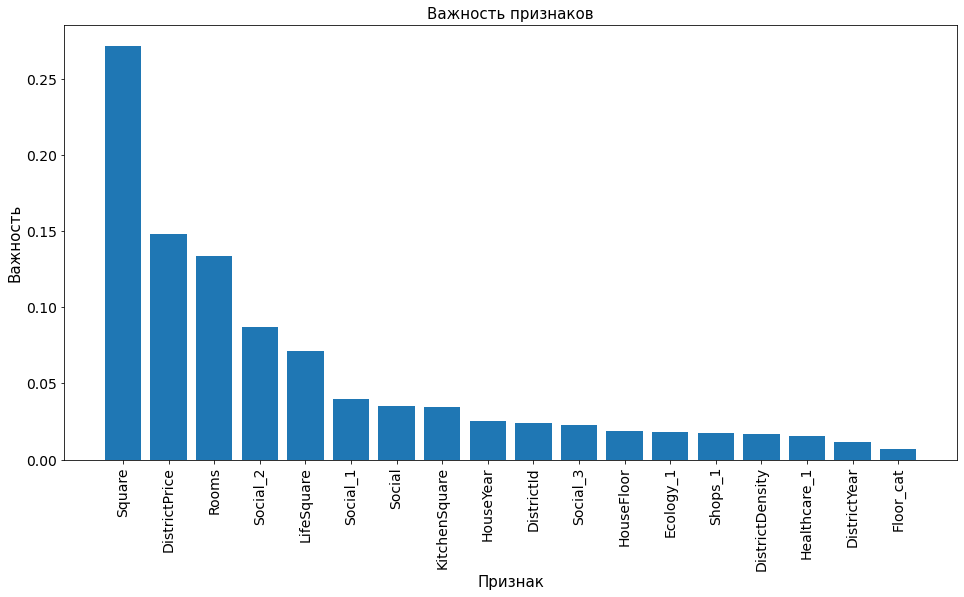

In [19]:
plt.figure(figsize = (16, 8))
plt.bar(feature_importances['feature_name'], feature_importances['importance'])
plt.xticks(rotation='90')
plt.xlabel('Признак', fontsize=15)
plt.ylabel('Важность', fontsize=15)
plt.title('Важность признаков', fontsize=15)
plt.show()

### Прогнозирование на тестовом датасете

In [20]:
test_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Shops_1,DistrictYear,DistrictDensity,DistrictPrice,Floor_cat,Social
0,44,1.0,36.847630,19.094182,5.0,9.0,1970.0,0.036122,24,4378,0,1036.0,1,1977.0,46.971646,4431.704675,1,-1.654285
1,62,1.0,42.568133,42.493907,10.0,17.0,2017.0,0.072158,2,629,1,2300.0,0,1977.0,56.667328,2859.977368,1,-1.462656
2,27,2.0,59.463678,38.570943,9.0,19.0,1977.0,0.211401,9,1892,0,900.0,1,1977.0,55.064041,2654.571480,3,-1.659865
3,23,3.0,49.646030,33.893825,6.0,2.0,1965.0,0.014073,2,475,0,0.0,0,1977.0,54.345128,2093.831883,0,-1.662911
4,74,1.0,53.837056,42.069644,1.0,17.0,1977.0,0.309479,35,7715,4,990.0,6,1977.0,56.148572,3483.810063,2,-0.847631


In [21]:
X_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Shops_1,DistrictYear,DistrictDensity,DistrictPrice,Floor_cat,Social
8785,134,2.0,39.697957,25.214448,7.0,9.0,1969.0,0.015017,17,3079,59,2300.0,8,1977.0,42.382091,6161.829301,1,10.186171
9074,8,1.0,39.195153,22.158768,9.0,12.0,1968.0,0.437885,23,5735,3,1084.0,5,1983.0,47.651571,3975.516530,2,-1.007192
8209,71,1.0,42.338652,20.734897,8.0,12.0,2001.0,0.033494,66,10573,1,1322.0,8,1984.0,43.604753,3946.969493,2,-1.393089
2018,30,3.0,83.770957,66.016766,1.0,12.0,2017.0,0.000078,22,6398,141,1046.0,23,1977.0,61.159895,2685.732205,2,26.592147
9408,26,3.0,64.626681,46.929294,9.0,12.0,1967.0,0.000000,36,6714,2,2300.0,2,1976.0,47.405424,4403.133589,1,-1.203879


In [22]:
# Этот файл тоже в этой же папке.
submit = pd.read_csv('sample_submission.csv') #'/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [23]:
predictions = gb_model.predict(test_df)
predictions

array([161954.55958412, 122736.40414539, 138279.48151338, ...,
       152216.01591424, 187903.57106991, 302422.20613178])

In [24]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,161954.559584
1,5925,122736.404145
2,960,138279.481513
3,3848,87158.254886
4,746,181250.330335


In [25]:
submit.shape

(5000, 2)

In [26]:
submit.to_csv('rf_submit.csv', index=False)